In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
df_trec = pd.read_parquet("../../../data/metadata_TREC.parquet")
df_ceur = pd.read_parquet("../../../data/metadata_CEUR.parquet")
df_lncs = pd.read_parquet("../../../data/metadata_LNCS.parquet")

df_lncs.loc[df_lncs['ID'] == "lncs_649", 'Section'] = "CLEF at SemEval 2007"

In [3]:
# Calculate the publication output per proceeding df by Publication Year

def paper_per_year(df):
    result = df['PubYear'].value_counts().reset_index()

    result.columns = ['year', 'count']
    result = result.sort_values(by='year').reset_index(drop=True)

    return result

In [4]:
paper_output_trec = paper_per_year(df_trec)
paper_output_lncs = paper_per_year(df_lncs)
paper_output_ceur = paper_per_year(df_ceur)

In [5]:
paper_output_trec['source'] = 'TREC'
paper_output_lncs['source'] = 'LNCS'
paper_output_ceur['source'] = 'CEUR'

In [6]:
combined_df = pd.concat([paper_output_trec, paper_output_lncs, paper_output_ceur])

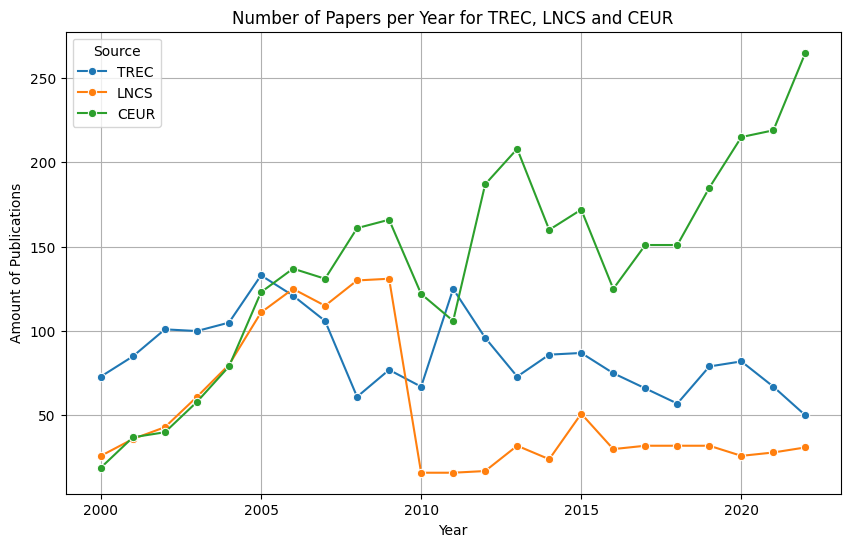

In [8]:
combined_df['year'] = pd.to_numeric(combined_df['year'])

plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_df, x='year', y='count', hue='source', marker='o')

plt.title('Number of Papers per Year for TREC, LNCS and CEUR')
plt.xlabel('Year')
plt.ylabel('Amount of Publications')
plt.legend(title='Source')
plt.grid(True)

plt.savefig('../../../images/output_per_year_lineshart.png', dpi=300)  

plt.show()

In [9]:
def calculate_coverage(path_OpenAlex, path_SemanticScholar, df):
    with open(path_OpenAlex, 'r', encoding="utf-8") as file:
        OpenAlexJson = json.load(file)
    with open(path_SemanticScholar, 'r', encoding="utf-8") as file:
        SemanticJson = json.load(file)
    paper_output = paper_per_year(df)

    df_cov_OpenAlex = df[df["ID"].isin(list(OpenAlexJson.keys()))]
    paper_cov_OpenAlex = paper_per_year(df_cov_OpenAlex)

    df_cov_SemanticScholar = df[df["ID"].isin(list(SemanticJson.keys()))]
    paper_cov_SemanticScholar = paper_per_year(df_cov_SemanticScholar)

    final = pd.merge(paper_output, paper_cov_OpenAlex, how="inner", left_on="year", right_on="year")
    final = pd.merge(final, paper_cov_SemanticScholar, how="inner", left_on="year", right_on="year")
    final.columns = ['year', 'Count (Total)', 'Count (OpenAlex)', 'Count (SemanticScholar)']

    return final 
    

In [13]:
final_lncs = calculate_coverage('../../../data/OpenAlex_LNCS.json', '../../../data/SemanticScholar_LNCS.json', df_lncs)
final_trec = calculate_coverage('../../../data/OpenAlex_TREC.json', '../../../data/SemanticScholar_TREC.json', df_trec)
final_ceur = calculate_coverage('../../../data/OpenAlex_CEUR.json', '../../../data/SemanticScholar_CEUR.json', df_ceur)

In [14]:
coverage = [[final_trec["Count (Total)"].sum() , final_trec["Count (OpenAlex)"].sum(), round((final_trec["Count (OpenAlex)"].sum()/final_trec["Count (Total)"].sum() )*100, 2), final_trec["Count (SemanticScholar)"].sum(), round((final_trec["Count (SemanticScholar)"].sum()/final_trec["Count (Total)"].sum() ) *100, 2)],
            [final_lncs["Count (Total)"].sum() , final_lncs["Count (OpenAlex)"].sum(), round((final_lncs["Count (OpenAlex)"].sum()/final_lncs["Count (Total)"].sum() )*100, 2) , final_lncs["Count (SemanticScholar)"].sum(), round((final_lncs["Count (SemanticScholar)"].sum()/final_lncs["Count (Total)"].sum()) *100, 2)],
            [final_ceur["Count (Total)"].sum() , final_ceur["Count (OpenAlex)"].sum(), round((final_ceur["Count (OpenAlex)"].sum()/final_ceur["Count (Total)"].sum() )*100, 2), final_ceur["Count (SemanticScholar)"].sum(), round((final_ceur["Count (SemanticScholar)"].sum()/final_ceur["Count (Total)"].sum() ) *100, 2)]
           ]

df_coverage = pd.DataFrame(coverage, columns=["Total Amount", "Found in OpenAlex", "% in OpenAlex", "Found in SemanticScholar", "% SemanticScholar"])
index_labels = ['TREC', 'LNCS', 'CEUR']
df_coverage = df_coverage.set_index(pd.Index(index_labels))

In [15]:
df_coverage.to_latex()

'\\begin{tabular}{lrrrrr}\n\\toprule\n & Total Amount & Found in OpenAlex & % in OpenAlex & Found in SemanticScholar & % SemanticScholar \\\\\n\\midrule\nTREC & 1972 & 1710 & 86.710000 & 1871 & 94.880000 \\\\\nLNCS & 1225 & 1225 & 100.000000 & 1187 & 96.900000 \\\\\nCEUR & 3217 & 2858 & 88.840000 & 3119 & 96.950000 \\\\\n\\bottomrule\n\\end{tabular}\n'